Importing the necessary libraries, and defining TESPy network fluids, units. Defined are sources and sink, which represent Power plant. 

In [19]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapefile
from shapely import wkt
import matplotlib.pyplot as plt


from tespy.components import source, sink, heat_exchanger_simple, pipe
from tespy.connections import connection, bus, ref
from tespy.networks import network

from sub_consumer import fork as fo


from functions import *



nw = network(fluids=['water'], T_unit='C', p_unit='bar', h_unit='kJ / kg')
so = source('source')
si = sink('sink')



THis is the manual cell of the code, CODE USER! has to define path to his raw data, which is represented by 4 tables: 
- pipes (containing geometry, DN,Year,Type...), 
- consumers (containing Power, geometry, Adress)
- Roughness (containing data how pipe roughness changes through years, since aging is not linear)
- Pipe data (Defines pipe atributes like heat transfer, roughness, diameter...)
It is possible to directly load shape files, but need to be changed into geopandas GeoDataFrame.

The end product of the is table of users with ADRESS,Power and geometry columns.
For pipes, end product is table of pipes with BUILD_DATE,DIMENSION,geometry,LENGTH,POSITION columns.

Then, we define paths to download folder and name of downloaded selected pipes, which we select for calculation in the selection phase.
In the end we define starting EPSG codes in which the input geometry data for pipes and users are imported. 

In [20]:
path_data_raw = "data/raw/"
df_pipes=pd.read_csv(path_data_raw + "Pipes")
df_users=pd.read_csv(path_data_raw + "Consumers.csv",sep=";",encoding = "ISO-8859-1")
Roughness = pd.read_csv(path_data_raw + "Roughness_aging.csv",sep=";", header = None)
df_pipe_data=pd.read_csv(path_data_raw + "Pipes_data.csv",sep=";",encoding = "ISO-8859-1")


#Define to W units, currently data of kW set to 1/2th of nominal user power, so the factor is 1000/2
Power_units = 500

#Define starting pipe, first start with known ID
start_pipe_ID = 1

#delete pipes with writing IDs in list
delete_pipes_IDs = [100000,100001]

#define pressure drop on user in Pascals, value has to be negative
user_p_drop = -0.75*10**5

#manipulating user data and creating GeoDataFrame
df_users = df_users.rename(columns={'COORDINATE X': 'x', 'COORDINATE Y': 'y','POWER [kW]':'Power'})
df_users = gpd.GeoDataFrame(df_users, geometry=gpd.points_from_xy(df_users.x, df_users.y))
df_users["Power"]=df_users["Power"]*Power_units

#manipulating pipe data and creating GeoDataFrame
df_pipes["geometry"] = df_pipes["geometry"].astype(str)
df_pipes["geometry"] = df_pipes["geometry"].apply(wkt.loads)
df_pipes = gpd.GeoDataFrame(df_pipes, geometry= df_pipes["geometry"])
df_pipes["LENGTH"] = df_pipes["geometry"].length
df_pipes = df_pipes.rename(columns={'NAZIVNI_PR': 'DIMENSION', 'DATUM_GRAD': 'BUILD_DATE','LENGTH_3D':"LENGTH","LEGA":"POSITION"})

#df_users_table - - this should output table of this cell and used for whole code !!!!!!!!!!!!!!!!!!!!!!!!
df_users=df_users[["ADRESS","Power","geometry"]]


#df_pipes table - this should output table of this cell and used for whole code !!!!!!!!!!!!!!!!!!!!!!!!
df_pipes=df_pipes[["BUILD_DATE","DIMENSION","geometry","LENGTH","POSITION"]].copy()


#define path to your downloads folder
path = "C:/Users/Gazvoda/Desktop/Magistrska/Suhadol_DHS/data/processed/"
#define name of Selectedpipes without the .txt, predefined is Selected_pipes
name_downloaded = "SelectedPipes"

#Here we define starting EPSG codes (currently Slovenian D96 coordinate system) in which the input geometry data for pipes and users are imported. 
pipesEPSG = "epsg:3912"
usersEPSG = "epsg:3912"



In next cell coordinates systems are changed to WGS 84 / Pseudo-Mercator coordinate systems, which allows importation of background maps.

In [21]:
df_pipes.crs = {'init': pipesEPSG}
df_pipes=df_pipes.to_crs("EPSG:3857")
df_users.crs = {'init': usersEPSG}
df_users=df_users.to_crs("EPSG:3857")

  return _prepare_from_string(" ".join(pjargs))

  return _prepare_from_string(" ".join(pjargs))



In the next block, data manipulation for pipes and users tables is done. End product for pipes table contains additional columns:
- ID, Age, node_ups, node dws, USER_ID

Node ups represent geometry of the pipe's upstream node, node dws represent geometry of the pipe's downstream node.
USER_ID tells you if pipe has any consumers attached (if it is end pipe) and which

End product for users table contains additional columns:
- USER_ID, ID, dist

ID is the nearest pipe, which user will be connected to, dist is distance to the pipe in meters.


In [22]:
df_users = Get_ID(df_users)
df_pipes = Get_age_ID_pipe(df_pipes)
df_users = ckdnearest(df_users, df_pipes)
df_pipes = Get_coords(df_pipes,df_users)

In the next block, selection process is done. Running it opens a new window with pipes and users. After selecting area of calculation with lasso select tool (normally all pipes are selected, but the tool comes handy if geometry data is faulty or if system is too big - selection is based on pipes, so there is no need to select users too), clicking select pipes and click open_file, then save it in your path folder (which is data processed folder in project folder), output is df_pipes_c and df_users_c, which are our selected pipes and users for calculation. REMINDER: if there is already a SelectedFiles document in processed data folder, a new window can simply be closed, and we skip to next block of code.

In [23]:
selection_tool(df_pipes,df_users)
selected_pipes = get_selected_pipes(df_pipes,path,name_downloaded)
selected_pipes = delete_pipes(delete_pipes_IDs,selected_pipes)
df_pipes = delete_df_pipes_columns(df_pipes)
df_pipes_c, df_users_c = calculation_pipes(selected_pipes,df_pipes,df_users)

In [39]:
df_pipes_c.head(5)

,BUILD_DATE,DIMENSION,geometry,LENGTH,POSITION,ID,Age,node_ups,node_dws,USER_ID
0,2013,65,"LINESTRING (1701849.940 5747074.620, 1701808.3...",29.427878,Insulated,1,8,POINT (1701849.940 5747074.620),POINT (1701808.390 5747067.588),NaN
1,2000,65,"LINESTRING (1701808.390 5747067.588, 1701803.9...",30.149627,Insulated,2,21,POINT (1701808.390 5747067.588),POINT (1701803.939 5747024.508),NaN
2,2000,65,"LINESTRING (1701803.939 5747024.508, 1701909.4...",116.516093,Insulated,3,21,POINT (1701803.939 5747024.508),POINT (1701909.427 5746894.836),NaN
3,2000,40,"LINESTRING (1701909.427 5746894.836, 1701912.1...",21.095023,Insulated,4,21,POINT (1701909.427 5746894.836),POINT (1701912.181 5746864.659),NaN
4,2000,32,"LINESTRING (1701909.427 5746894.836, 1701886.5...",16.031220,Insulated,6,21,POINT (1701909.427 5746894.836),POINT (1701886.523 5746896.356),NaN


In [40]:
df_users_c.head(5)

,USER_ID,ADRESS,Power,geometry,ID,dist
0,1.0,GORENJI SUHADOL 1,5000,POINT (1701937.902 5746850.200),5,17.496617
2,23.0,GORENJI SUHADOL 23,40000,POINT (1701351.387 5747402.524),15,9.630789
4,24.0,GORENJI SUHADOL 24,4000,POINT (1701381.610 5747445.514),17,16.713513
7,25.0,GORENJI SUHADOL 25,4000,POINT (1701377.463 5747487.191),17,34.528638
10,26.0,GORENJI SUHADOL 26,6500,POINT (1701364.760 5747538.955),17,84.808577


In the next line, a function DHS_map that is used for vizualization is used (It can be used before selection process). It has following parametres:
- PIPES:
- pipes (currently df_pipes_c, is a table with pipes info)
- start_pipe_ID (defined in manual block of code at the begining is used for Plant location and plotting)
- linewidth_column (is a column from pipes table, which we want to use for width of the plotted pipes, default: DIMENSION)
- linewidth_factor (is a value, with which we manipulate thickness of pipes to a sensible result)
- color_presentation (is a name of the column which we want to use for colors of the pipes, default: Age)
- CONSUMERS:
- users (currently df_users_c, is a table with users info)
- markersize_users_factor (is a value, with which we manipulate the size of markers representing user power)
- cons_annotation (is a value that defines if users are annotated or not, True/False, default: False)
- cons_annotation_column (is a column that we want to use as annotation text, default: USER_ID)

  ctx.add_basemap(ax,url=ctx.sources.OSM_C, zoom=16)



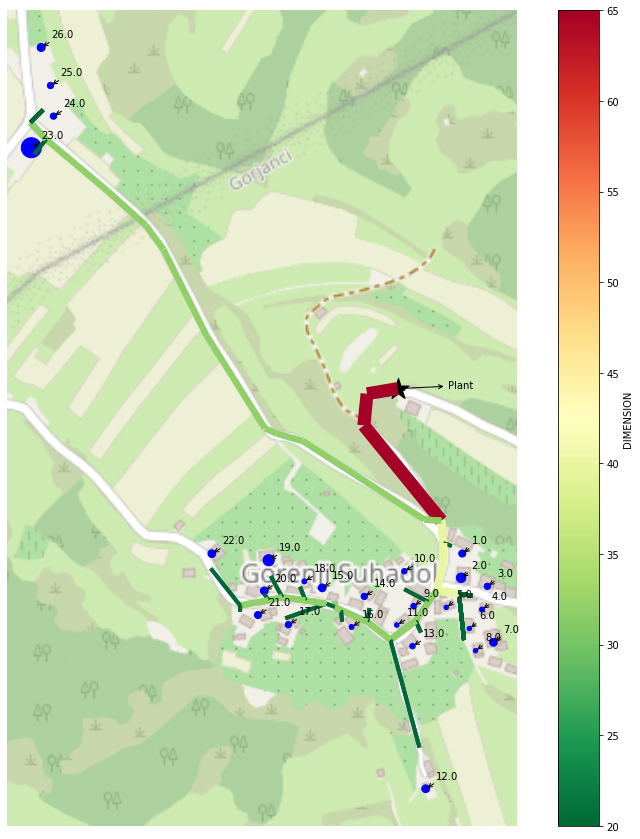

In [30]:
DHS_map(df_pipes_c,df_users_c,start_pipe_ID,linewidth_factor=1/5,markersize_users_factor = 1/100)

In the next block of code, following operations are done:
- created is df_pipes_data table, which contains all pipe attributes (roughness, diameter, heat transfer coefficent). It is based on initial input pipe_data and roughness. For every pipe, based on it's type, age and diameter, appropriate values are calculated and put into table.
- created is df_connections_table, which contains ID,next pipes ID and previous pipe IDs for current pipe. It is possible, that pipe has two next pipes, in which case, current row (ID) is doubled, the only difference between two rows is ID_next. For example, if pipe with ID 9, has previous pipe of ID 8 and next pipes with IDs 10 and 11:
  - first row: ID:9, ID_previous:8, ID_next:10
  - second row: ID:9, ID_previous:8, ID_next:11
- based on connections table, forks (when 1 pipe splits into 2) are defined, end pipes are defined, and tables with specific connecion type are defined:
  - pipe_pipe, pipe_user, user_pipe, fork_pipe, pipe_fork

In [7]:
df_pipe_data = pipe_data(df_pipe_data)
df_pipes_data = pipes_characteristics(df_pipe_data,Roughness,df_pipes_c)
df_connections = connections_ready_for_checking_downstream(df_pipes_c)
check_downstream(start_pipe_ID, df_connections)

df_forks_data,df_connections_saved = get_forks_data(df_connections)
df_connections = get_fork_exit(df_connections_saved,df_users_c,df_forks_data)

closest_pipes = get_closest_pipes(df_connections,df_pipes_c,df_users_c,df_users)

df_pipes_c = df_pipes_c.drop_duplicates(subset = "ID")


end_pipes=end_pipes_f(df_connections,closest_pipes,user_p_drop)

df_pipe_user = get_pipe_user_connections(df_connections)
df_pipe_pipe = get_pipe_pipe_connections(df_connections)
df_fork_pipe = get_fork_pipe_connections(df_connections)
df_pipe_fork = get_pipe_fork_connections(df_connections)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_c_pure["USER_ID"]=df_users_c_pure["USER_ID"].astype(int)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_c_pure["USER_ID"]=df_users_c_pure["USER_ID"].astype(int)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_c_pure["USER_ID"]=df_users_c_pure["USER_ID"].astype(int)

A va

Next block, TESPy objects are defined:
- feed pipes (pf)
- return pipes (pb)
- fork (f)
- consumers (cons)
- connections
Tespy uses those object for calculation.

In [8]:
pf = pipe_feed_definition(df_pipes_data)
pb = pipe_return_definition(df_pipes_data)
k = forks(df_forks_data)

nw = add_subsys(k,nw)

cons = consumers(end_pipes)

so_start = define_connections_so_start(start_pipe_ID,pf,so)
start_si = define_connections_start_si(start_pipe_ID,pb,si)
pipe_pipe_f = define_connections_pipe_pipe_feed(df_pipe_pipe,pf)
pipe_pipe_b = define_connections_pipe_pipe_back(df_pipe_pipe,pb)
pipe_user = define_connections_pipe_user(df_pipe_user,end_pipes,pf,cons)
user_pipe = define_connections_user_pipe(end_pipes,pb,cons,pipe_user)
fork_pipe_f1 = define_connections_fork_pipe_1_feed(df_fork_pipe,k,pf)
fork_pipe_b1 = define_connections_fork_pipe_1_back(df_fork_pipe,k,pb)
fork_pipe_f2 = define_connections_fork_pipe_2_feed(df_fork_pipe,k,pf)
fork_pipe_b2 = define_connections_fork_pipe_2_back(df_fork_pipe,k,pb)
pipe_fork_f = define_connections_pipe_fork_feed(df_pipe_fork,df_fork_pipe,k,pf)
pipe_fork_b = define_connections_pipe_fork_back(df_pipe_fork,df_fork_pipe,k,pb,fork_pipe_b1)


nw = add_connections(nw,
                     so_start,
                     start_si,
                     pipe_pipe_f,
                     pipe_pipe_b,
                     pipe_user,
                     user_pipe,
                     fork_pipe_f1,
                     fork_pipe_b1,
                     fork_pipe_f2,
                     fork_pipe_b2,
                     pipe_fork_f,
                     pipe_fork_b)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pipe_user["USER_ID"]=df_pipe_user["USER_ID"].astype(int)



Defining busses for TESPy:

In [9]:
heat_losses = bus('network losses')
heat_consumer = bus('network consumer')
nw.check_network()
nw.add_busses(heat_losses, heat_consumer)

  arr_value = np.array(value)



Defininf boundary conditions for calculation:
    - so_start represents starting conditions in the plant
    - so_start represents returning conditions to the plant
    - user_pipe represents connection between user and first return pipe, defining Temperature here defines the temp. that user will return back to the network.
    - Tamb is the ambient temperature


In [10]:
so_start.set_attr(T = 80)   
so_start.set_attr(p = None)  
start_si.set_attr(p = 4.5)  
start_si.set_attr(T = None) 
for element in user_pipe:
    user_pipe[element].set_attr(T=55)

for comp in nw.comps.index:
    if isinstance(comp, pipe):
        comp.set_attr(Tamb=0)

        heat_losses.add_comps({'comp': comp})
        comp.char_warnings=False

    if (isinstance(comp, heat_exchanger_simple) and
            not isinstance(comp, pipe)):
        heat_consumer.add_comps({'comp': comp})
        comp.char_warnings=False


Calculation, Warning: for init_path There has to be a folder with grid calculation results already (first calculation is done without it). 

In [ ]:
nw.solve('design',init_path = "Suhadol_DHS")


Saving grid results for easier next calculation, (this grid is then used as init_path in next rerun)

In [12]:
nw.save("Suhadol_DHS")

In the next line the results are added to tables os users and pipes:
- T_feed and p_feed to users table, table with results is called df_users_results
- pipe_heat_losses to every pipe, table with results is called df_pipes_results

In [13]:
df_pipes_results,df_users_results = get_results(df_pipes_c,end_pipes,df_users_c,pf,user_pipe,pipe_user,df_users)

In next line, some of the most needed results info is printed:

In [14]:
print_results(heat_consumer,heat_losses,so_start)

PRINTED RESULTS:
Heat demand consumer: -152.5 kW 
 Network losses: -41.85 kW
 Network losses: 21.53 %
 Source feed temperature: 80.0 °C
 Source feed mass flow: 1.69 kg/s
 Source feed pressure: 6.59 bar


Again DHS_map is used, but this time with different parametres, annotation is used for determining user feed temperature, and for pipes, heat losses are the area of interest.

  ctx.add_basemap(ax,url=ctx.sources.OSM_C, zoom=16)



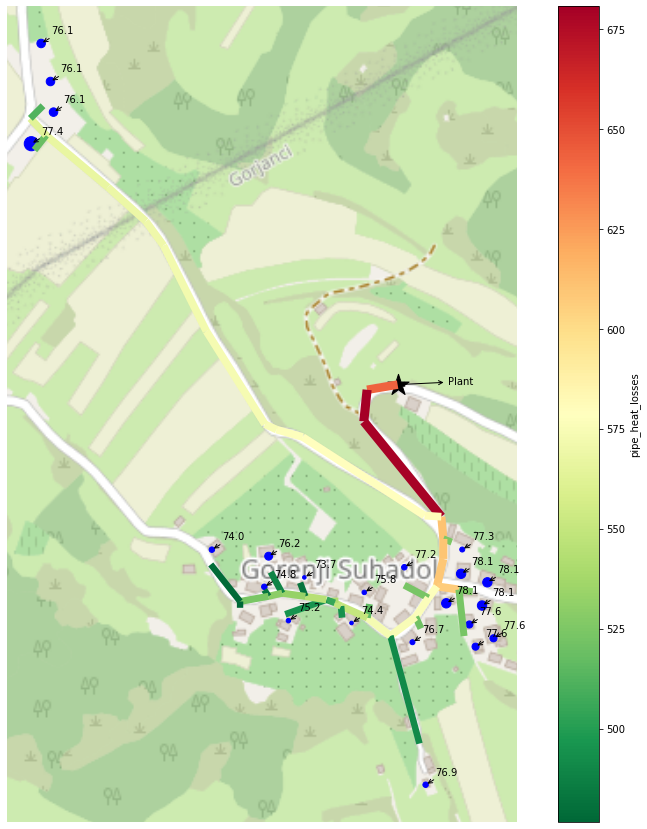

In [43]:
DHS_map(df_pipes_results,
        df_users_results,
        start_pipe_ID,
        color_presentation = "pipe_heat_losses",
        linewidth_column = "pipe_heat_losses", 
        linewidth_factor = 1/75,
        markersize_users_factor = 1/200,
        cons_annotation = True,
        cons_annotation_column = "T_feed")

In [42]:
df_pipes_results.head(5)

,BUILD_DATE,DIMENSION,geometry,LENGTH,POSITION,ID,Age,node_ups,node_dws,USER_ID,pipe_heat_losses
0,2013,65,"LINESTRING (1701849.940 5747074.620, 1701808.3...",29.427878,Insulated,1,8,POINT (1701849.940 5747074.620),POINT (1701808.390 5747067.588),NaN,642.392626
1,2000,65,"LINESTRING (1701808.390 5747067.588, 1701803.9...",30.149627,Insulated,2,21,POINT (1701808.390 5747067.588),POINT (1701803.939 5747024.508),NaN,680.624908
2,2000,65,"LINESTRING (1701803.939 5747024.508, 1701909.4...",116.516093,Insulated,3,21,POINT (1701803.939 5747024.508),POINT (1701909.427 5746894.836),NaN,679.814463
3,2000,40,"LINESTRING (1701909.427 5746894.836, 1701912.1...",21.095023,Insulated,4,21,POINT (1701909.427 5746894.836),POINT (1701912.181 5746864.659),NaN,611.266728
4,2000,32,"LINESTRING (1701909.427 5746894.836, 1701886.5...",16.031220,Insulated,6,21,POINT (1701909.427 5746894.836),POINT (1701886.523 5746896.356),NaN,580.412331


In [44]:
df_users_results.head(5)

,ADRESS,geometry,ID,USER_ID,Power,p_return,T_feed
0,GORENJI SUHADOL 1,POINT (1701937.902 5746850.200),5,1,5000,5.669671,77.255207
1,GORENJI SUHADOL 2,POINT (1701936.350 5746817.165),21,2,17500,5.475242,78.116300
2,GORENJI SUHADOL 3,POINT (1701972.103 5746805.543),21,3,17500,5.475242,78.116300
3,GORENJI SUHADOL 4,POINT (1701964.830 5746773.966),21,4,17500,5.475242,78.116300
4,GORENJI SUHADOL 5,POINT (1701916.159 5746777.017),21,5,17500,5.475242,78.116300
